In [1]:
# imports

import matplotlib.pyplot as plt
import scipy as scp
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.special import erfc
from scipy.optimize import brent
from scipy.signal import convolve2d
from model import *
from param import Params

import numpy as np
from model import *

In [2]:
# functions

gaussian = norm.pdf


class snorm:
    def pdf(x,chi,omega,alpha,der=0):
        if der == 0:
            return 1/omega*norm.pdf((x-chi)/omega)*erfc(-alpha*(x-chi)/omega)    
        elif der == 1:
            return 2*alpha/omega**2*norm.pdf((x-chi)/omega)*norm.pdf(alpha*(x-chi)/omega)-(x-chi)/omega**3*norm.pdf((x-chi)/omega)*erfc(-alpha*(x-chi)/omega)
    def mean(chi,omega,alpha):
        delta = alpha*(1+alpha**2)**-0.5
        return chi + omega*delta*(2/np.pi)**0.5
    def variance(chi,omega,alpha):
        delta = alpha*(1+alpha**2)**-0.5
        return omega**2 * (1-2*delta**2/np.pi)
    def skewness(chi,omega,alpha):
        delta = alpha*(1+alpha**2)**-0.5
        return (4-np.pi)/2 * (delta*(2/np.pi)**0.5)**3 * (1-2*delta**2/np.pi)**(-3/2)
    def kurtosis(chi,omega,alpha):
        delta = alpha*(1+alpha**2)**-0.5
        return 2*(np.pi-3) * (delta*(2/np.pi)**0.5)**4 * (1-2*delta**2/np.pi)**-2
    def mode(chi,omega,alpha):        
        delta = alpha*(1+alpha**2)**-0.5
        muz = (2/np.pi)**0.5*delta
        sigmaz = (1-muz**2)**0.5
        gamma1 = snorm.skewness(chi,omega,alpha) 
        m0 = muz - gamma1*sigmaz/2 - np.sign(alpha)/2 * np.exp(-2*np.pi/np.abs(alpha))
        return chi + omega*m0
    

linemod = lambda x,d,chi,omega,alpha: 1-d*snorm.pdf(x,chi,omega,alpha)/snorm.pdf(snorm.mode(chi,omega,alpha),chi,omega,alpha)

def fake_spec(l,p):
    '''
    l: numper of lines
    p: number of points
    '''
    x = np.linspace(0,1,p)
    depth_ = 1/(1+np.abs(np.random.normal(4,4,l)))
    chi_ = np.random.rand(l)
    omega_ = 1/(1+np.abs(np.random.normal(400,150,l)))
    alpha_ = np.random.normal(0.2,1,l)
    
    #return 1- 10**np.sum(np.log10([snorm.pdf(x, chi_[i], omega_[i], alpha_[i]) for i in range(l)]),axis=0)
    return np.prod(np.array([linemod(x, depth_[i], chi_[i], omega_[i], alpha_[i]) for i in range(l)]),axis=0)

In [3]:
# main

# Generate template spectrum

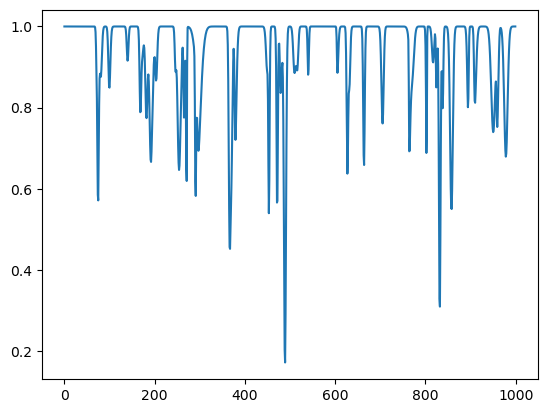

In [4]:
# generate a spectrum
f_star = fake_spec(50,1000)

plt.figure()
plt.plot(f_star)

# Initialize Model

In [5]:
# Initialize model
wave_j = np.arange(len(f_star))+1
lnwave_j = np.log(wave_j)
spec_cell_j = 1
S_star = scp.interpolate.interp1d(lnwave_j,f_star)
fluxes_molec = []
IP_v = IP
IP_y = IP_sg

S_mod = model(S_star, lnwave_j, spec_cell_j, fluxes_molec, IP_v, IP_y, func_norm=poly, IP_v_hs=50, IP_y_hs=50, xcen=0)

# Generate Data with the Model

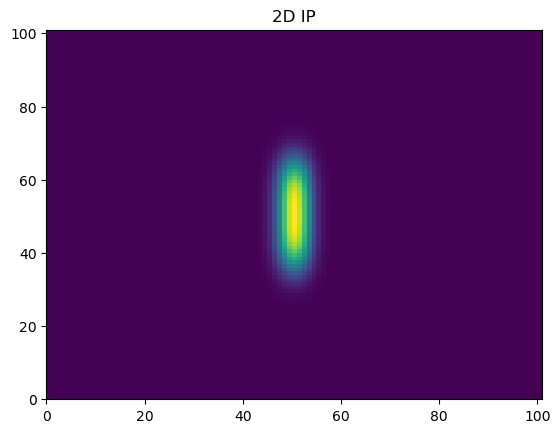

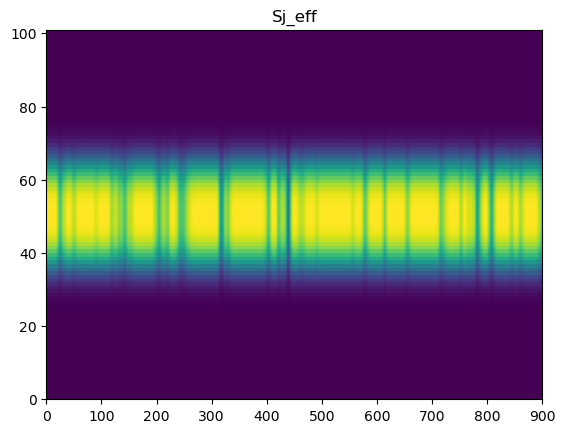

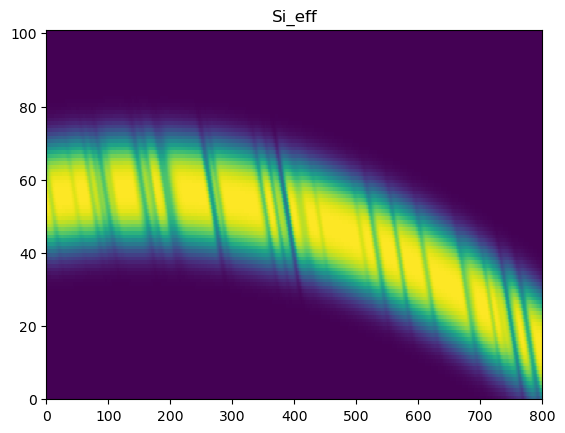

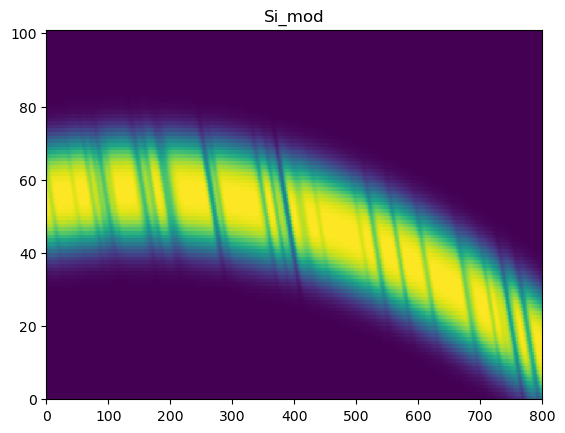

In [6]:
# Call the model with some sample inputs

coeff_wave = np.array([wave_j[len(wave_j)//2],wave_j[1]-wave_j[0]]).astype(float)
pixel_coords = np.meshgrid(np.arange(len(wave_j))[100:-100],np.arange(101))
# centre coordinates
pixel_coords[0] = pixel_coords[0]-np.mean(pixel_coords[0]) 
pixel_coords[1] = pixel_coords[1]-np.mean(pixel_coords[1]) 

par_true = Params(wave=coeff_wave,
                  pixel_shift_x=[0,1], pixel_shift_y=[0,0.02,0.0001], pixel_rot=0.01*np.pi,
                  ip_v=[5e5],ip_y=[15,3.2],
                 # ip_phi=0,ip_shift_y=[0],ip_shift_v=[0],
                 ) 
S_obs = S_mod(pixel_coords,
              lookip=True,lookS=True,
              **par_true)
#valid = np.isfinite(S_obs)
#S_obs[~valid] = 0
eS_obs = S_obs**0.5
eS_obs += eS_obs.max()/100

# Print or use the result as needed
#plt.figure()
#plt.plot(S_star(lnwave))
#plt.figure()
#plt.title('Simulated Observation')
#plt.pcolormesh(S_obs)

#  Fit the simulated Observation 

Try to recover the input parameters.

In [7]:
par_init = Params(wave=coeff_wave,
                  pixel_shift_x=[0,1.1], pixel_shift_y=[0,0.022], pixel_rot=0.011*np.pi,
                  ip_v=[5.5e5],ip_y=[15.15,3.2],
                 # ip_phi=0,ip_shift_y=[0],ip_shift_v=[0],
                 ) 
par_init.ip_y[0].unc = 0

par_fit, epar_fit = S_mod.fit(pixel_coords, S_obs, par_init, sig=eS_obs)

In [8]:
eS_obs.shape

(101, 800)

In [9]:
par_init.ip_y[0].unc = 0
par_init.vary()

{('wave', 0): 501.0,
 ('wave', 1): 1.0,
 ('pixel_shift_x', 0): 0,
 ('pixel_shift_x', 1): 1.1,
 ('pixel_shift_y', 0): 0,
 ('pixel_shift_y', 1): 0.022,
 'pixel_rot': 0.03455751918948772,
 ('ip_v', 0): 550000.0,
 ('ip_y', 1): 3.2}

In [10]:
# compute model
S_fit = S_mod(pixel_coords,**par_fit)

# initial 
S_init = S_mod(pixel_coords,**par_init)

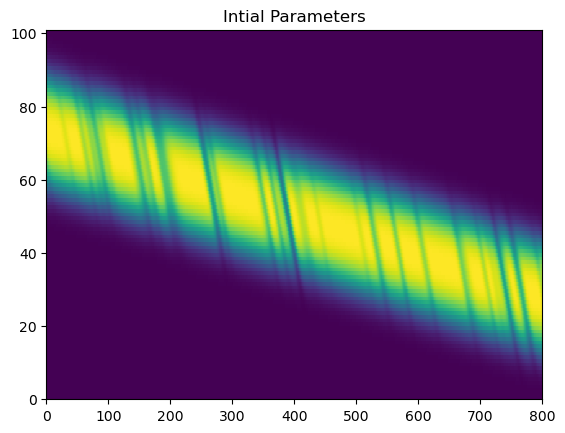

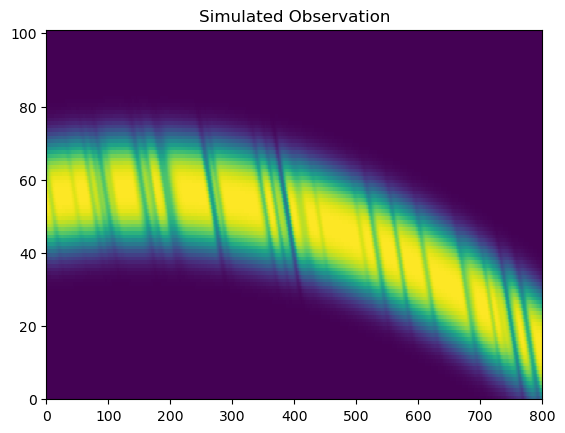

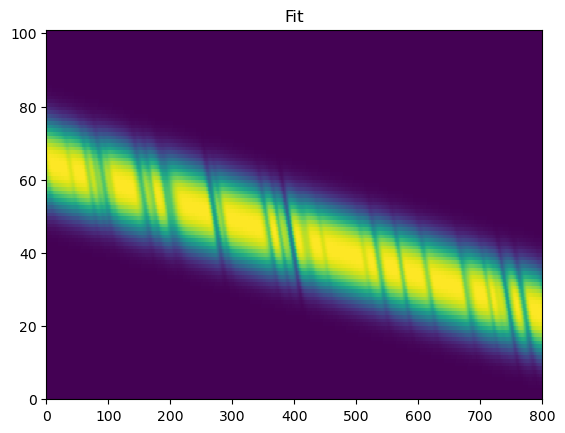

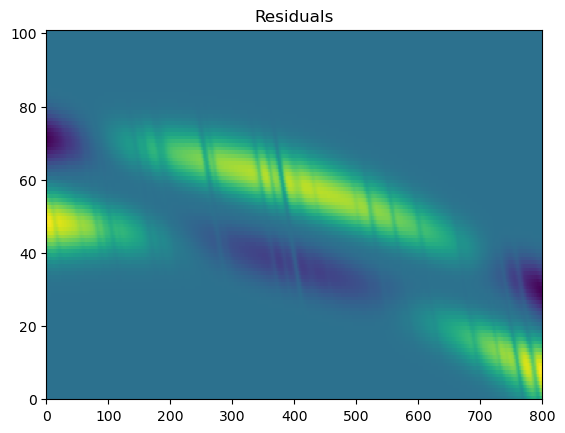

In [11]:
# Plot fit results


plt.figure()
plt.title('Intial Parameters')
plt.pcolormesh(S_init)


plt.figure()
plt.title('Simulated Observation')
plt.pcolormesh(S_obs)

plt.figure()
plt.title('Fit')
plt.pcolormesh(S_fit)

plt.figure()
plt.title('Residuals')
plt.pcolormesh(S_obs-S_fit)

In [12]:
# Print out initial Parameters
print("\nInitial Parameters:")
print(par_init)

# Print out fitted parameters with uncertainties
print("\nFitted Parameters with Uncertainties:")
print(par_fit)

# Print out true parameters
print("\nTrue Parameters:")
print(par_true)


Initial Parameters:
wave: [501.0, 1.0]
pixel_shift_x: [0, 1.1]
pixel_shift_y: [0, 0.022]
pixel_rot: 0.03455751918948772
ip_v: [550000.0]
ip_y: [15.15 ± 0, 3.2]

Fitted Parameters with Uncertainties:
wave: [540.2573210745207 ± 9.706567746688702, 1.413531051186102 ± 0.008340166768793754]
pixel_shift_x: [-27.73282612164956 ± 6.872527453358502, 0.09246127114775894 ± 0.006544045952316166]
pixel_shift_y: [8.428249148317995 ± 0.02293418737993831, 0.8720404390688564 ± 0.003008685599283525]
pixel_rot: -0.6659317358180733 ± 0.0017099537687286775
ip_v: [503783.51781477535 ± 19096.753473308177]
ip_y: [15.15 ± 0, 2.7524788849494954 ± 0.01209162979230383]

True Parameters:
wave: [501.0, 1.0]
pixel_shift_x: [0, 1]
pixel_shift_y: [0, 0.02, 0.0001]
pixel_rot: 0.031415926535897934
ip_v: [500000.0]
ip_y: [15, 3.2]
